Import Libraries

In [28]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup

print('Libraries imported!')

Libraries imported!


Get data from WikiPedia and make DataFrame 'df'

In [2]:
# download data and parse it:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')
table = soup.find('table', attrs={'class':'wikitable sortable'})

# get headers:
headers = table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")

# Find all items and skip first one:
rows = table.findAll('tr')
rows = rows[1:len(rows)]

# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")

# make dataframe, expand rows and drop the old one:
df = pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n = 2, expand = True) 
df.drop(columns = [0],inplace = True)

# extract titles from columns
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand = False))

df.update(
    df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand = False))

df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park


Only process the cells that have an assigned borough

In [3]:
#skip not assigned boroughs:
df = df.drop(df[(df.Borough == "Not assigned")].index)

df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


Combine multiple neighborhood in one postal code area: combine into one row with the neighborhoods separated with a comma

In [4]:
# combine multiple neighborhoods with the same post code
df2 = pd.DataFrame({'Postcode':df.Postcode.unique()})
df2['Borough'] = pd.DataFrame(list(set(df['Borough'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood'] = pd.Series(list(set(df['Neighbourhood'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood'] = df2['Neighborhood'].apply(lambda x: ', '.join(x))
df2.dtypes

df2.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park (Toronto)
5,M9A,Queen's Park (Toronto),Not assigned
6,M1B,"Scarborough, Toronto","Malvern, Toronto, Rouge, Toronto"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


If a cell has a borough but a not assigned neighborhood, then the neighborhood will be the same as the borough

In [5]:
# give "Not assigned" Neighborhoods same name as Borough:
df2.Neighborhood.replace("Not assigned", df.Borough, inplace=True)

df2.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park (Toronto)
5,M9A,Queen's Park (Toronto),North York
6,M1B,"Scarborough, Toronto","Malvern, Toronto, Rouge, Toronto"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe:

In [6]:
df2.shape

(103, 3)

Use the csv file to create a dataframe with Longitude and Latitude

In [11]:
#add Geo-spatial data
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.rename(columns={'Postal Code':'Postcode'}, inplace = True)
dfll.set_index("Postcode")
df2.set_index("Postcode")
df3 = pd.merge(df2, dfll)
df3.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park (Toronto),43.662301,-79.389494
5,M9A,Queen's Park (Toronto),North York,43.667856,-79.532242
6,M1B,"Scarborough, Toronto","Malvern, Toronto, Rouge, Toronto",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe:

In [20]:
df3.shape

(103, 5)

In [26]:
df4 = df3[['Latitude','Longitude']]
df4.head(10)

,Latitude,Longitude
0,43.753259,-79.329656
1,43.725882,-79.315572
2,43.654260,-79.360636
3,43.718518,-79.464763
4,43.662301,-79.389494
5,43.667856,-79.532242
6,43.806686,-79.194353
7,43.745906,-79.352188
8,43.706397,-79.309937
9,43.657162,-79.378937


Import MatPlotLib & KMeans

In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
print('Library imported!')

Library imported!


Create a Scatter Chart of L&L

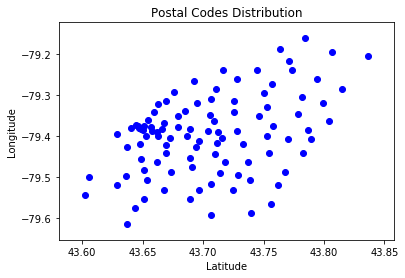

In [36]:
plt.scatter(df4['Latitude'],df4['Longitude'], color = 'blue')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Postal Codes Distribution")
plt.show()

Group Postal Codes into 5 clusters with K-MEANS

In [60]:
# set number of clusters
clusters = 5

# run k-means clustering
kmeans = KMeans (init="k-means++", n_clusters = clusters, random_state = 0).fit(df4)

#check cluster labels generated for each row in the dataframe
kmeans_labels = kmeans.labels_
kmeans_labels

array([4, 4, 2, 3, 2, 1, 0, 4, 4, 2, 3, 1, 0, 4, 4, 2, 2, 1, 0, 4, 2, 2,
       0, 4, 2, 2, 0, 3, 3, 4, 2, 2, 0, 3, 3, 4, 2, 2, 0, 3, 3, 4, 2, 2,
       4, 3, 1, 4, 2, 1, 1, 0, 3, 1, 4, 3, 1, 1, 4, 3, 1, 3, 3, 1, 1, 0,
       3, 3, 2, 1, 1, 0, 3, 3, 2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2,
       1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 1, 2, 4, 1, 1], dtype=int32)

Identification of Centroids

In [61]:
kmeans_cluster_center = kmeans.cluster_centers_
kmeans_cluster_center

array([[ 43.77480817, -79.24566825],
       [ 43.68190854, -79.52763743],
       [ 43.66242868, -79.39708912],
       [ 43.75057744, -79.41419236],
       [ 43.70021343, -79.32439325]])